
# Defining Dynamic FBA model for a single species




## Import headers



In [1]:
%matplotlib inline
import cobra
import PyDSTool as dst
import pandas as pd
import matplotlib.pyplot as plt
import copy
import sys

:RESULTS:
nil:END:




## File Paths for Media spec and FBA model



In [2]:
model = cobra.io.read_sbml_model('./data/Bacteroides_sp_1_1_14.xml')
mediaFluxes = pd.read_csv('./data/VMH_HighFiber.tsv', sep='\t')

:RESULTS:
nil:END:




## Extract exchange reactions into variable definition and ics dictionary



In [3]:
def cleanupname(name):
    """
    The reaction names in the model files 
    don't have brackets or parentheses. I replaced
    those found in the mediaFluxes file.
    """
    name = name.replace('[', '_LPAREN_')
    name = name.replace(']', '_RPAREN_')
    name = name.replace('(', '_LPAREN_')
    name = name.replace(')', '_RPAREN_')
    return name

"""
Initialize dictionaries for defining the ODE variables for a 
single species
"""

VarDef = dict()
ParDef_base = dict()
ICS_base = dict()

solution = model.optimize() # Get fluxes
all_exchanges = model.exchanges
media_derived_components = dict()

exchange_reaction_ids = [rxn.id for rxn in all_exchanges]



### Extract the reaction names and flux values into a dictionary.



In [4]:
for i, row in mediaFluxes.iterrows():
    N = cleanupname(row.Reaction)
    media_derived_components[N] = row['Flux Value'] / (24.0*60.0) # Per minute

:RESULTS:
nil:END:




### Get the outfluxes



In [5]:
# out_fluxes = []
# for k in all_exchanges:
#     if k.reversibility and k.id not in media_derived_components.keys():
#         out_fluxes.append(k.id)

ParDef_base['mu'] = solution.objective_value/60.0
VarDef['X'] =  'mu * X'
ICS_base['X'] = 1e-1
# for r in all_exchanges:
#     if r.id in media_derived_components.keys():
#         ParDef_base[r.id + '_influx'] = media_derived_components[r.id]
#         ParDef_base[r.id + '_consumption'] = solution.fluxes[r.id]
#         ICS_base[r.id] = 0 #media_derived_components[r.id]
#         VarDef[r.id] = r.id + '_influx + ' + r.id + '_consumption' + ' * X'
#     if r.id in out_fluxes:
#         ParDef_base[r.id + '_outflux'] = solution.fluxes[r.id] 
#         VarDef[r.id] = r.id + '_outflux * X'
#         ICS_base[r.id] = 0.0
for r in all_exchanges:
    ParDef_base[r.id + '_Bact'] = solution.fluxes[r.id]/60
    if r.id in media_derived_components.keys():
        ParDef_base[r.id + '_influx'] = media_derived_components[r.id]
        VarDef[r.id] = r.id + '_influx +' + r.id + '_Bact' + ' * X'
    else: 
        VarDef[r.id] =  r.id + '_Bact' + ' * X'
    ICS_base[r.id] = 1
#     if r.id in out_fluxes:
#         ParDef_base[r.id + '_outflux'] = solution.fluxes[r.id] 
#         VarDef[r.id] = r.id + '_outflux * X'
#         ICS_base[r.id] = 0.0

:RESULTS:
nil:END:




## Define PyDSTool Model



In [6]:
TSPAN = 100

ParDef = copy.deepcopy(ParDef_base)
ICS = copy.deepcopy(ICS_base)
def simulateModel(ModelDS, ParDef, ICS, TSPAN, tstart):
    ModelDS.set(ics=ICS ,pars=ParDef,tdata=[tstart, tstart + TSPAN])
    P = ModelDS.compute('test').sample(dt=0.1)
    return(P)
ParDef = copy.deepcopy(ParDef_base)
ICS = copy.deepcopy(ICS_base)
ModelDef =dst.args(name='Bacteroides',
                  varspecs=VarDef,
                  pars=ParDef,
                  ics=ICS,
                  )

ModelDS = dst.Vode_ODEsystem(ModelDef)

# P = simulateModel(ModelDS, ParDef, ICS,TSPAN, 0.0)
# for variable in VarDef.keys():
#     if P[variable][-1] < 0.0:
#         for i in range(0, len(P[variable])):
#             if P[variable][i] < 0.0:
#                 print(variable, i, P['t'][i])
#                 sys.exit()
P= {}
#P['X'] = [1e-1]
for k in ICS_base.keys():
    P[k] = [ICS_base[k]]

:RESULTS:
nil:END:



In [7]:
ICS['X']

0.1


## Create Upperlimit



In [8]:
AllPoints = []
#AllPoints.append(P)
OriginalLB = {}
model_copy = copy.deepcopy(model)
T0=0

for r in model_copy.reactions:
    if r in model_copy.exchanges:
        OriginalLB[r.id] = r.lower_bound

NegativeCrossing = []
Lstop=len(P['X'])
for i in range(0, 8):
    print(T0)
    #solution = model_copy.optimize()
    all_exchanges = model_copy.exchanges
    for r in all_exchanges:
#         if r.id in media_derived_components.keys():
#             model_copy.reactions.get_by_id(r.id).lower_bound = OriginalLB[r.id]*P[r.id][-1]/(0.0005+P[r.id][-1])
        model_copy.reactions.get_by_id(r.id).lower_bound = OriginalLB[r.id]*P[r.id][-1]/(0.05+P[r.id][-1])

#         if r.id == 'EX_adn_L_LPAREN_e_RPAREN_':
#             print(r.id + ': ' +str(OriginalLB[r.id]) + ' -> ' + str(model_copy.reactions.get_by_id(r.id).lower_bound))
    solution = model_copy.optimize()
    for variable in NegativeCrossing:
        print(variable, ' LB = ', model_copy.reactions.get_by_id(variable).lower_bound)
        print(variable, 'flux', solution.fluxes[variable])

    ParDef['mu'] = solution.objective_value/60.0
    ICS['X'] = P['X'][-1]
    for r in all_exchanges:
        ParDef[r.id + '_Bact'] = solution.fluxes[r.id]/60 
        ICS[r.id] = P[r.id][-1]
#     for r in all_exchanges:
#         if r.id in media_derived_components.keys():
#             ParDef[r.id + '_influx'] = media_derived_components[r.id]
#             ParDef[r.id + '_consumption'] = solution.fluxes[r.id]
#             ICS[r.id] = P[r.id][-1]
#         if r.id in out_fluxes:
#             ParDef[r.id + '_outflux'] = solution.fluxes[r.id] 
#             ICS[r.id] = P[r.id][-1] # 0.0
    #del P
    P = simulateModel(ModelDS, ParDef, ICS,TSPAN, T0)
    TSTOP = T0+TSPAN
    AllNegativeValues = {}
    Lstop=len(P['X'])-1
    NegativeCrossing = []
    
    for variable in VarDef.keys():
        if P[variable][-1] < 0.0:
            val = next((index for index,value in enumerate(P[variable]) if value < 0), None)
            if val < Lstop:
                        TSTOP = P['t'][val]
                        Lstop = val
                        print()
    
    print('Lstop =', Lstop)
    print("len(P['X']) =", len(P['X']))
    if Lstop<len(P['X'])-1:
        B={}
        for variable in VarDef.keys():
            B[variable]=P[variable][:Lstop-1]
            if P[variable][Lstop]<0:
                print(variable)
                B[variable][-1]=0
                NegativeCrossing.append(variable)
#         P[variable] = list(P[variable])[:Lstop]
        B['t']=P['t'][:Lstop-1]
        P=B
    TSTOP = P['t'][-1]


                        
#             for l in range(0, len(P[variable])):
#                 if P[variable][l] < 0.0:
#                     if P['t'][l] < TSTOP:
#                         TSTOP = P['t'][l]
#                         Lstop = l
#                         VarStor = variable
#                     break
                    
#     for variable in VarDef.keys():
#         if P[variable][Lstop] < 0
#         for t in len(P[variable]):
#             if P[variable][t] < 0:
#                 NegativeCrossing[variable] = P['t'][t]
                    
#     NegativeCrossing = {}
#     for variable in VarDef.keys():
#         for t in len(P[variable]):
#             if P[variable][t] < 0:
#                 NegativeCrossing[variable] = P['t'][t]
    
#     print("TSTOP = " + str(TSTOP))
#     TSTOP = P['t'][Lstop-1]
#     print("TSTOP = " + str(TSTOP))

#     if TSTOP-T0 < TSPAN:
#         P = simulateModel(ModelDS, ParDef, ICS, TSTOP-T0, T0)


#         for variable in VarDef.keys():
#             if P[variable][-1] < 0:
#                 P[variable][-1] = 0
        
    #P = simulateModel(ModelDS, ParDef, ICS,TSPAN, T0)

#    print('EX_glu_L_LPAREN_e_RPAREN_' + str(P['EX_glu_L_LPAREN_e_RPAREN_'][-1]))
    
    T0 = TSTOP

    AllPoints.append(P)

0
Lstop = 1000
len(P['X']) = 1001
100.0
Lstop = 1000
len(P['X']) = 1001
200.0
Lstop = 1000
len(P['X']) = 1001
300.0

Lstop = 824
len(P['X']) = 1001
EX_adn_LPAREN_e_RPAREN_
EX_acgam_LPAREN_e_RPAREN_
EX_no2_LPAREN_e_RPAREN_
EX_2obut_LPAREN_e_RPAREN_
EX_h_LPAREN_e_RPAREN_
EX_cytd_LPAREN_e_RPAREN_
382.1982198219822
EX_adn_LPAREN_e_RPAREN_  LB =  -0.0
EX_adn_LPAREN_e_RPAREN_ flux -0.0
EX_acgam_LPAREN_e_RPAREN_  LB =  -0.0
EX_acgam_LPAREN_e_RPAREN_ flux -0.0
EX_no2_LPAREN_e_RPAREN_  LB =  -0.0
EX_no2_LPAREN_e_RPAREN_ flux -0.0
EX_2obut_LPAREN_e_RPAREN_  LB =  -0.0
EX_2obut_LPAREN_e_RPAREN_ flux -0.0
EX_h_LPAREN_e_RPAREN_  LB =  -0.0
EX_h_LPAREN_e_RPAREN_ flux 0.17717088044081986
EX_cytd_LPAREN_e_RPAREN_  LB =  -0.0
EX_cytd_LPAREN_e_RPAREN_ flux -0.0
Lstop = 1000
len(P['X']) = 1001
482.1982198219822
Lstop = 1000
len(P['X']) = 1001
582.1982198219822
Lstop = 1000
len(P['X']) = 1001
682.1982198219822
Lstop = 1000
len(P['X']) = 1001


1000


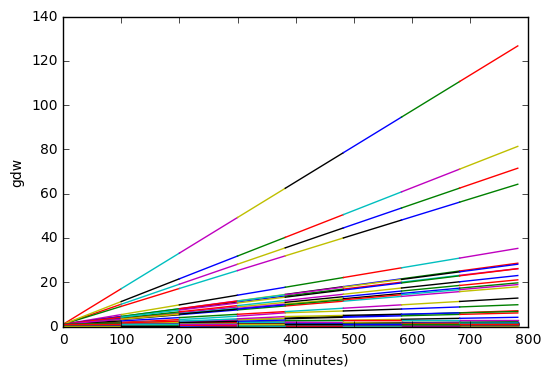

In [9]:
print(Lstop)
T=[]
X=[]
for v in VarDef.keys():
        for P in AllPoints:
                if 'h2o' not in v :
                       # print(v)
                        T = P['t']
                        X = P[v]
                        plt.plot(T,X)
#                 T = P['t']
#                 X = P['X']
#                 plt.plot(T,X)

plt.xlabel('Time (minutes)')
plt.ylabel('gdw')

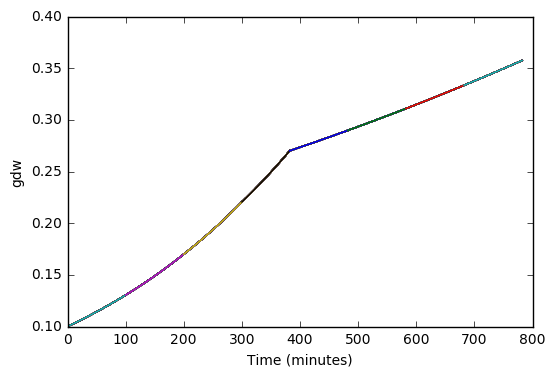

In [10]:
T=[]
X=[]
for v in VarDef.keys():
        for P in AllPoints:
#                 if 'h2o' not in v :
#                        # print(v)
#                         T = P['t']
#                         X = P[v]
#                         plt.plot(T,X)
                T = P['t']
                X = P['X']
                plt.plot(T,X)

plt.xlabel('Time (minutes)')
plt.ylabel('gdw')

In [11]:
for k in media_derived_components.keys():
    if 'asn' in k:
        print(k)

In [12]:
for rxn in model.exchanges:
    print(rxn.reversibility)

False
True
True
True
True
True
True
True
False
True
False
True
False
True
True
False
False
False
True
True
False
True
False
False
True
True
True
True
True
True
False
False
True
True
True
True
False
False
False
False
True
False
True
True
True
True
True
True
False
True
False
False
False
False
True
False
False
True
True
False
True
True
True
True
False
True
False
True
False
True
True
False
False
True
True
True
True
True
True
False
False
True
True
True
True
False
True
True
True
True
True
False
False
False


In [13]:
A = [1, 2, 3, 4, 5, 6]
print(len(A))
print(A[5])
del A[4:end]

6
6


NameError: name 'end' is not defined